# NVIDIA AI Foundation Endpoints

The `NVIDIA` and `ImageGenNVIDIA` classes are LLM-inheriting connectors that interface with the [NVIDIA AI Foundation Endpoints](https://www.nvidia.com/en-us/ai-data-science/foundation-models/).


> [NVIDIA AI Foundation Endpoints](https://www.nvidia.com/en-us/ai-data-science/foundation-models/) give users easy access to NVIDIA hosted API endpoints for NVIDIA AI Foundation Models like Mixtral 8x7B, Llama 2, Stable Diffusion, etc. These models, hosted on the [NVIDIA NGC catalog](https://catalog.ngc.nvidia.com/ai-foundation-models), are optimized, tested, and hosted on the NVIDIA AI platform, making them fast and easy to evaluate, further customize, and seamlessly run at peak performance on any accelerated stack.
> 
> With [NVIDIA AI Foundation Endpoints](https://www.nvidia.com/en-us/ai-data-science/foundation-models/), you can get quick results from a fully accelerated stack running on [NVIDIA DGX Cloud](https://www.nvidia.com/en-us/data-center/dgx-cloud/). Once customized, these models can be deployed anywhere with enterprise-grade security, stability, and support using [NVIDIA AI Enterprise](https://www.nvidia.com/en-us/data-center/products/ai-enterprise/).
> 
> These models can be easily accessed via the [`langchain-nvidia-ai-endpoints`](https://pypi.org/project/langchain-nvidia-ai-endpoints/) package, as shown below.

This example goes over how to use LangChain to interact with and develop LLM-powered systems using the publicly-accessible AI Foundation endpoints.

## Installation

In [1]:
# %pip install --upgrade --quiet langchain-nvidia-ai-endpoints

## Setup

**To get started:**

1. Create a free account with the [NVIDIA NGC](https://catalog.ngc.nvidia.com/) service, which hosts AI solution catalogs, containers, models, etc.

2. Navigate to `Catalog > AI Foundation Models > (Model with API endpoint)`.

3. Select the `API` option and click `Generate Key`.

4. Save the generated key as `NVIDIA_API_KEY`. From there, you should have access to the endpoints.

In [2]:
import getpass
import os

if not os.environ.get("NVIDIA_API_KEY", "").startswith("nvapi-"):
    nvapi_key = getpass.getpass("Enter your NVIDIA API key: ")
    assert nvapi_key.startswith("nvapi-"), f"{nvapi_key[:5]}... is not a valid key"
    os.environ["NVIDIA_API_KEY"] = nvapi_key

## Accessing Raw LLM Endpoints

Though progressively becoming less common in services, raw LLM interfaces offer the most amount of flexibility with regard to prompting and output sampling. Unlike chat models which operate on `List[ChatMessages] -> AIMessage` logic, raw endpoints expect a "prompt" as input and return "text" as output.

In [3]:
## Core LC Chat Interface
from langchain_nvidia_ai_endpoints import NVIDIA

NVIDIA.get_available_models()

[Model(id='starcoder2_15b', model_type='completion', client='NVIDIA', path='6acada03-fe2f-4e4d-9e0a-e711b9fd1b59')]

As we can see, the AI Foundation Endpoints currently only host a single publicly-available LLM endpoint: `starcoder2_15b`. [**`StarCoder2`**](https://github.com/bigcode-project/starcoder2) is a model developed by [BigCode](https://www.bigcode-project.org) in collaboration with NVIDIA, and you can read more about the model in the [related blog post](https://developer.nvidia.com/blog/unlock-your-llm-coding-potential-with-starcoder2/). The following will import the model for us: 

In [4]:
from langchain_nvidia_ai_endpoints import NVIDIA

starcoder = NVIDIA(model="starcoder2_15b")

print(starcoder.invoke("Here is my implementation of fizzbuzz:\n```python\n", stop="```"))
# for txt in starcoder.stream("Here is my implementation of fizzbuzz:\n```python\n", stop=["```"]):
#     print(txt, end="")

def fizzbuzz(n):
    for i in range(1, n+1):
        if i % 3 == 0 and i % 5 == 0:
            print("FizzBuzz")
        elif i % 3 == 0:
            print("Fizz")
        elif i % 5 == 0:
            print("Buzz")
        else:
            print(i)


Reading through the [related publication](https://arxiv.org/abs/2402.19173), we can see that it is especially suited for code completion, so in this case a message-based interface is suboptimal. Instead, it may be more useful to use the appropriate tags (i.e. `<jupyter_code>` and `<intermediate_to_code>`):

In [5]:
from langchain_nvidia_ai_endpoints import NVIDIA

starcoder = NVIDIA(model="starcoder2_15b", frequency_penalty=2, max_tokens=64)

print("Priors from <jupyter_code>")
for txt in starcoder.stream("<jupyter_code>\n", stop=["</jupyter_code>"]):
    print(txt, end="")

print("\n\nPriors from <code_to_intermediate>")
for txt in starcoder.stream("<code_to_intermediate>\n", stop=["</code_to_intermediate>"]):
    print(txt, end="")

print("\n\nPriors from <intermediate_to_code>")
for txt in starcoder.stream("<intermediate_to_code>\n", stop=["</intermediate_to_code>"]):
    print(txt, end="")

Priors from <jupyter_code>
# 1. Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Read the data as a data frame
df = pd.read_csv("https://raw.githubusercontent.com/TrainingByPackt

Priors from <code_to_intermediate>
define i32 @main(i32 %argc, ptr nocapture readonly %argv) local_unnamed_addr personality ptr @seq_personality {
entry:
  %0 = alloca i8, align 1
  %1 = alloca i8, align 1
  %2

Priors from <intermediate_to_code>
#include <iostream>
#include <string>
#include <vector>
#include <algorithm>
#include <sstream>
#include <queue>
#include <deque>
#include <bitset>
#include <iterator>
#include <list>
#include

### Stream, Batch, and Async

These models natively support streaming and expose a batch method to handle concurrent requests, as well as async methods for invoke, stream, and batch. Below are a few examples.

In [6]:
print(starcoder.batch(["What's 2*3?", "What's 2*6?"]))
# Or via the async API
# await starcoder.abatch(["What's 2*3?", "What's 2*6?"])

["What's 2*3?\n\nWhat's 2*3?\n\nWhat's 2*3?\n\nWhat's 2*3?\n\nWhat's 2*3?\n\nWhat's 2*3?\n\nWhat's 2*3?", "## 12. What's 2*7?\n\n## 13. What's 2*8?\n\n## 14. What's 2*9?\n\n## 15. What's 2*10?\n\n## 16."]


In [7]:
for chunk in starcoder.stream("How far can a seagull fly in one day?"):
    # Show the token separations
    print(chunk, end="|")

A| se|ag|ull| can| fly| 2|0| km| in| one| hour|.| How| far| can| it| fly| in| one| day|?|
•| A|ircraft|
The| plane| f|lies| at| an| alt|itude| of| 6|5|0|0| m| above| the| ground| at| speed| 7|7|7| km|/|h|.| At| what| alt|itude| will| the||

In [8]:
async for chunk in starcoder.astream(
    "How long does it take for monarch butterflies to migrate?"
):
    print(chunk, end="|")

Mon|arch| butter|f|lies| migrate| from| M|ex|ico| to| California|.| They| spend| about| 1|0|0| days| in| M|ex|ico| and| 1|0|0| days| in| California|.|

###| Example| Question| #|1| :| How| Long| Does| It| Take| For| Mon|arch| B|utter|f|lies| To Migrate|?|

How| long| does|

## Image Generation Models

Due to the similarity of the underlying API, a selection of **Image Generation Models** can be supported using the LLM interface. One example is the [**Stable Diffusion XL**](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/ai-foundation/models/sdxl/api) model, which expects a prompt and some other arguments as input and produces an image (passed back as a b64-encoded string). 

In [18]:
from langchain_nvidia_ai_endpoints import ImageGenNVIDIA

ImageGenNVIDIA.get_available_models()  ## Only shows models supported by ImageGenNVIDIA

sdxl = ImageGenNVIDIA(model="sdxl")

out = sdxl.invoke("A picture of a cat, aesthetic")
out[:100] + "..."

'b64_json: /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDg...'

To see the image, we can either convert it manually or use the built-in conversion utility ``

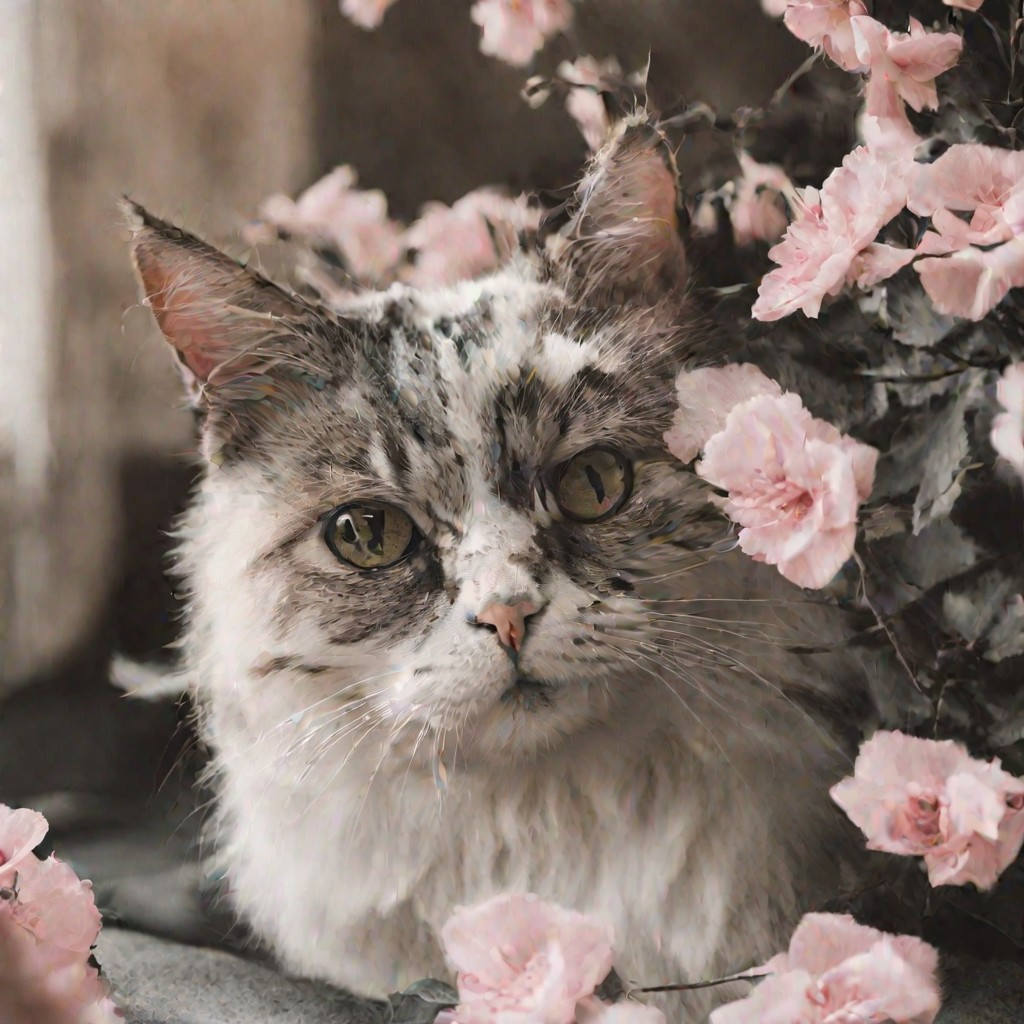

In [19]:
from langchain_nvidia_ai_endpoints.image_gen import ImageParser

# from io import BytesIO
# from PIL import Image
# import base64

# Image.open(BytesIO(base64.decodebytes(bytes(out[10:], "utf-8"))))
ImageParser().invoke(out)  ## Runnable that does it all for you

In addition to the prompt, we can do a bit of hyperparameter tweaking and add some negative prompt components that we'd like to avoid. We will also use the `ImageParser` runnable automatically by calling the `.as_pil()` method.

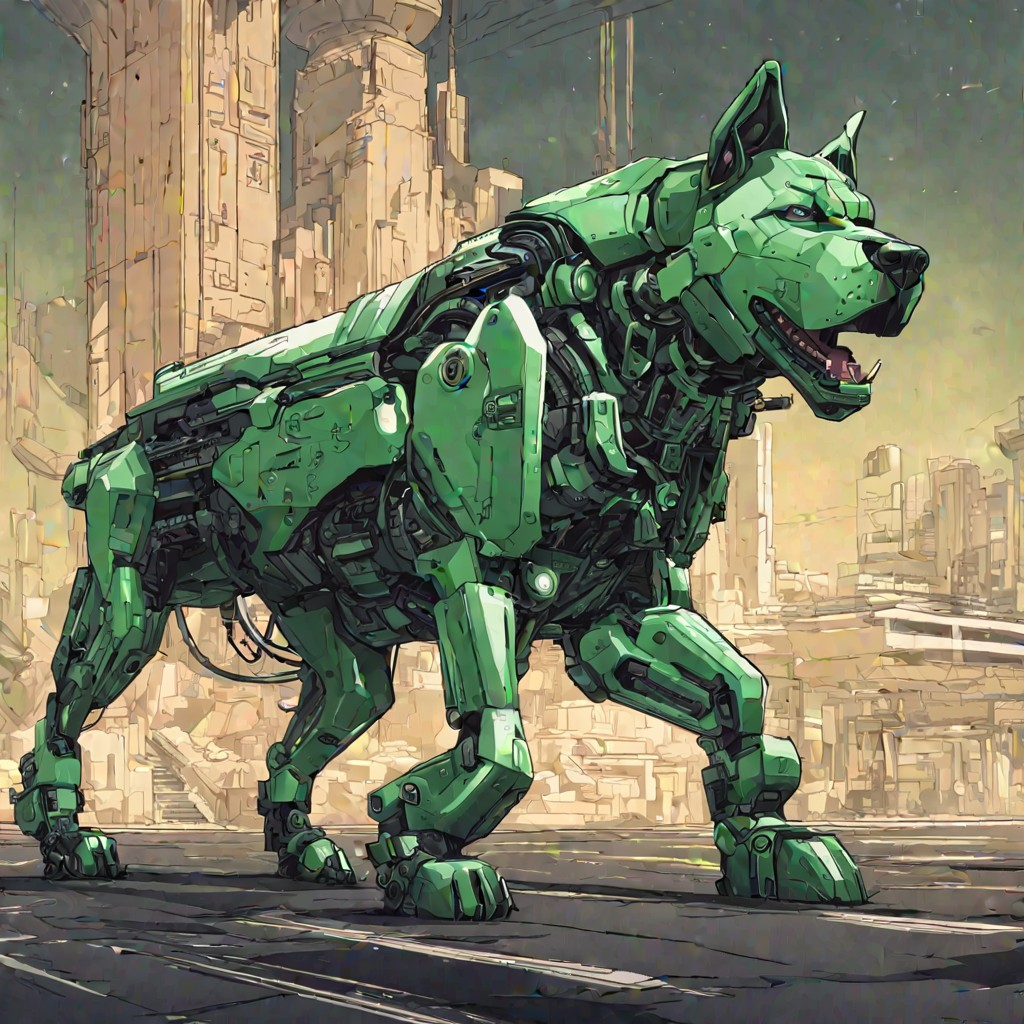

In [11]:
sdxl = ImageGenNVIDIA(
    inference_steps = 100,
    negative_prompt = "ugly,bad eyes,low-res,crooked nose, smudged, painted",
)

sdxl.as_pil().invoke("A picture of a big green dog, futuristic cyberpunk")

Note that under the hood, `as_pil` returns a merger of the `ImageGenModel` object with the `ImageParser` output parser. As a result, you may have trouble interacting with the aggregation. Note that you can reference the first half of the pipeline via `.first` or similar.

## Using with OpenAI

In [12]:
from langchain_nvidia_ai_endpoints import NVIDIA
from getpass import getpass
import os

if not os.environ.get("OPENAI_API_KEY", "").startswith("sk-"):
    os.environ["OPENAI_API_KEY"] = getpass("Enter your OPENAI Key: ")

llm = NVIDIA().mode("openai")
llm.available_models

[Model(id='babbage-002', model_type='completion', client='NVIDIA', path='system'),
 Model(id='davinci-002', model_type='completion', client='NVIDIA', path='system'),
 Model(id='gpt-3.5-turbo-instruct-0914', model_type='completion', client='NVIDIA', path='system'),
 Model(id='gpt-3.5-turbo-instruct', model_type='completion', client='NVIDIA', path='system')]

In [13]:
llm = NVIDIA(model="gpt-3.5-turbo-instruct").mode("openai")

print("Trying Out Invoke")
print(llm.invoke("Here is my implementation of fizzbuzz:\n```python\n", stop="```", max_tokens=100))

print("\nTrying Out Streaming")
starter = "Here is my implementation of fizzbuzz in python:\n```\ndef fizzbuzz(n):\n\t"
print(starter, end="")
for txt in llm.stream(starter, stop=["```"], max_tokens=100):
    print(txt, end="")

Trying Out Invoke
# Define a function fizzbuzz that takes in a number n and prints out the corresponding fizzbuzz sequence
def fizzbuzz(n):
    # Loop through numbers from 1 to n
    for num in range(1, n+1):
        # Check if current number is divisible by 3 and 5
        if num % 3 == 0 and num % 5 == 0:
            # If so, print "FizzBuzz"
            print("FizzBuzz")
        #

Trying Out Streaming
Here is my implementation of fizzbuzz in python:
```
def fizzbuzz(n):
	"""
	Prints the numbers from 1 to n.
	Multiples of 3 are replaced by "Fizz".
	Multiples of 5 are replaced by "Buzz".
	Multiples of both 3 and 5 are replaced by "FizzBuzz".
	"""
	for i in range(1, n+1):
		if i%3 == 0 and i%5 == 0:
			print("FizzBuzz")
		elif i%3 == 0:
			print("Fizz

In [14]:
from langchain_nvidia_ai_endpoints import ImageGenNVIDIA
from getpass import getpass
import os

if not os.environ.get("OPENAI_API_KEY", "").startswith("sk-"):
    os.environ["OPENAI_API_KEY"] = getpass("Enter your OPENAI Key: ")

llm = ImageGenNVIDIA().mode("openai")
llm.available_models

[Model(id='dall-e-2', model_type='image_out', client='ImageGenNVIDIA', path='system'),
 Model(id='dall-e-3', model_type='image_out', client='ImageGenNVIDIA', path='system')]

In [ ]:
from langchain_nvidia_ai_endpoints import ImageGenNVIDIA

dalle = ImageGenNVIDIA().mode("openai", model="dall-e-3")

def payload_fn(d):
    if d:
        drop_keys = ["guidance_scale", "seed", "negative_prompt", "sampler"]
        d = {k: v for k, v in d.items() if k not in drop_keys}
    return d

dalle.client.payload_fn = payload_fn

dalle.as_pil().invoke("City skyline, neon green tint, aesthetic futuristic realistic")

In [16]:
print(dalle.client.last_inputs['json'])
dalle.client.last_response.json()

{'prompt': 'City skyline, neon green tint, aesthetic futuristic realistic', 'model': 'dall-e-3'}


{'created': 1710164575,
 'data': [{'revised_prompt': "Visualize an aesthetic and realistic city skyline. The skyline is bathed in a neon green tint contributing to a futuristic atmosphere. The sky scrapers are designed with a blend of contemporary and future architectural styles, capturing the essence of a technologically advanced society. Street lights and billboards glow with radiant neon colors, reflecting on the glass surfaces of the buildings. The scene gives off an aura of an exciting and vibrant future city after dusk. It's an urban landscape intertwining nature's beauty with human-made structures.",
   'url': 'https://oaidalleapiprodscus.blob.core.windows.net/private/org-UOJTPbi1KQQDRdYIgJfVPkYK/user-KFXSm8ag8jgNs5P6PfjZDoIb/img-tUrcDqGQKfnswGruJRHVPOjM.png?st=2024-03-11T12%3A42%3A55Z&se=2024-03-11T14%3A42%3A55Z&sp=r&sv=2021-08-06&sr=b&rscd=inline&rsct=image/png&skoid=6aaadede-4fb3-4698-a8f6-684d7786b067&sktid=a48cca56-e6da-484e-a814-9c849652bcb3&skt=2024-03-11T05%3A11%3A23Z&sk